In [1]:
#!/usr/bin/env python2
# coding: utf-8

# FROM plot_absolute_maps_GCaMP.ipnb (JNB)

%matplotlib inline


import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd
#import matplotlib.pyplot as plt
import copy
import colorsys

import math
# get_ipython().magic(u'matplotlib inline')

def get_thresholded_maps(phase_map, ratio_map, threshold):
    phase_mask = copy.deepcopy(phase_map)
    phase_mask[ratio_map < threshold] = np.nan
    phase_mask = np.ma.array(phase_mask)
    return phase_mask


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

import matplotlib.cm as cm
import numpy.linalg as la
import scipy.ndimage as ndimage
#import json

from json import dumps, loads, JSONEncoder, JSONDecoder
import pickle

class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (list, dict, str, unicode, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct



In [6]:
# options:
# parser = optparse.OptionParser()
# parser.add_option('--headless', action="store_true", dest="headless", default=False, help="run in headless mode, no figs")
# parser.add_option('--reduce', action="store", dest="reduce_val", default="2", help="block_reduce value")
# parser.add_option('--path', action="store", dest="path", default="", help="path to data directory")
# # parser.add_option('-t', '--thresh', action="store", dest="threshold", default=0.5, help="cutoff threshold value")
# parser.add_option('-r', '--run', action="store", dest="run", default=1, help="cutoff threshold value")
# parser.add_option('--append', action="store", dest="append", default="", help="appended label for analysis structs")
# parser.add_option('-M', '--map', action="store", dest="maptype", type="choice", choices=['absolute', 'combo'], default='absolute', help="Method for creating phase maps [absolute | combo]")
# parser.add_option('-C', '--cmap', action="store", dest="cmap", default='spectral', help="colormap for summary figures [default: spectral]")
# parser.add_option('--smooth', action="store_true", dest="smooth", default=False, help="smooth? (default sig = 2)")
# parser.add_option('--sigma', action="store", dest="sigma_val", default=2, help="sigma for gaussian smoothing")

# # parser.add_option('--contour', action="store_true", dest="contour", default=False, help="Show contour lines for phase map")
# # parser.add_option('--power', action='store_true', dest='use_power', default=False, help="Use power or just magnitude?")


# parser.add_option('--noclean', action='store_false', dest='get_clean', default=True, help="Save borderless, clean maps for COREG")

# parser.add_option('--threshold', action="store", dest="threshold", default=0.01, help="Threshold (max of ratio map)")
# parser.add_option('--alpha', action="store", dest="alpha_val", default=0.5, help="Alpha value for overlays")

# parser.add_option('--short-axis', action="store_false", dest="use_long_axis", default=True, help="Used short-axis instead of long?")
# parser.add_option('--combo', action="store_true", dest="show_combo", default=False, help="Show combined maps or only save single runs?")
# parser.add_option('--new', action="store_true", dest="create_new", default=False, help="Create new map struct or no?")

# parser.add_option('--exclude', action="store", dest="exclude", default='avg', help='string to exclude from append variable')

# parser.add_option('--delay', action="store_true", dest=delay_mask, default=False, help='Use delay map to mask invalid delays for absolute phase.')
# parser.add_option('-dthr', '--delaythresh', action="store", dest=delay_thr, default=0.5, help='If using delay map to threshold abs phase, sets bounds for valid delays [default 0.5].')

# parser.add_option('--combo', action="store_true", dest=get_combo, default=False, help='Get combined AZ/EL maps for GCaMP by averaging conjugated maps.')


# (options, args) = parser.parse_args()

# delay_mask = options.delay_mask
# delay_thr = options.delay_thr

# maptype = options.maptype
# exclude = options.exclude
# create_new = options.create_new
# get_combo = options.get_combo
# show_combo = options.show_combo
# get_clean = options.get_clean

# smooth = options.smooth
# sigma_val_num = options.sigma_val
# sigma_val = (int(sigma_val_num), int(sigma_val_num))

# # contour = options.contour
# # use_power = options.use_power

# headless = options.headless
# reduce_val = int(options.reduce_val)
# reduce_factor = (int(options.reduce_val), int(options.reduce_val))
# if reduce_factor[0] > 1:
#     reduceit=1
# else:
#     reduceit=0
# if headless:
#     import matplotlib as mpl
#     mpl.use('Agg')

# import matplotlib.pyplot as plt

# colormap = options.cmap

# threshold = float(options.threshold)
# outdir = options.path
# run_num = options.run

get_combo = False

delay_mask = False
delay_thr = 1.5

maptype = 'asbsolute'
exclude = 'avg'
create_new = True
show_combo = False
get_clean = True

smooth = False
sigma_val_num = 1
sigma_val = (int(sigma_val_num), int(sigma_val_num))

headless = False
reduce_val = 2
reduce_factor = (int(reduce_val), int(reduce_val))
if reduce_factor[0] > 1:
    reduceit=1
else:
    reduceit=0
if headless:
    import matplotlib as mpl
    mpl.use('Agg')

import matplotlib.pyplot as plt

colormap = 'hsv' #options.cmap

threshold = 0.2 #float(options.threshold)
alpha_val = 0.5

outdir = '/nas/volume1/widefield/data/JR041W/20170404'#options.path
#run_num = options.run

append = '' #options.append

In [7]:
subject = os.path.split(os.path.split(outdir)[0])[1]
date = os.path.split(outdir)[1]
conditions = os.listdir(outdir)
conditions = [i for i in conditions if subject in i and 'Hz' in i]

print "EXPT: ", date
print "CONDITIONS: ", conditions

composite_dir = os.path.join(outdir, 'composite')
fig_dir = os.path.join(composite_dir, 'figures')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

EXPT:  20170404
CONDITIONS:  ['JR041W_bar_028Hz', 'JR041W_flash_short_bar_028Hz', 'JR041W_short_bar_028Hz', 'JR041W_flash_bar_028Hz']


In [8]:
# --------------------------------------------------------------------
# Get blood vessel image:
# --------------------------------------------------------------------

folders = os.listdir(outdir)
figpath = [f for f in folders if f == 'surface']
if not figpath:
    figpath = [f for f in folders if f == 'figures']
print "path to surface: ", figpath

if figpath:
    # figdir = figpath[0]
    figpath=figpath[0]
    tmp_ims = os.listdir(os.path.join(outdir, figpath))
    surface_words = ['surface', 'GREEN', 'green', 'Surface', 'Surf']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    ims = [i for i in ims if date in i]
    # print ims
    if ims:
        impath = os.path.join(outdir, figpath, ims[0])
        print os.path.splitext(impath)[1]
        if os.path.splitext(impath)[1] == '.tif':
            tiff = TIFF.open(impath, mode='r')
            surface = tiff.read_image().astype('float')
            tiff.close()
        else:
            image = Image.open(impath) #.convert('L')
            surface = np.asarray(image)
    else:
        surface = np.zeros([200,300])
    print surface.shape
else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])
    print "No blood vessel image found. Using empty."

if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)
    print "Reduced image to: ", surface.shape


path to surface:  ['surface']
.tif
(246, 328)
Reduced image to:  (123, 164)


In [11]:
struct_fns = os.listdir(outdir)
struct_fns = [f for f in struct_fns if os.path.splitext(f)[1] == '.pkl' and 'r'+str(reduce_val) in f]

if len(struct_fns) > 1 and create_new is False:
    if len(struct_fns) == 1: # composite struct exists
        composite_struct_fn = os.path.join(outdir, struct_fns[0])

    elif len(struct_fns) > 1:
        print "Found more than 1 composite struct file for session %s: " % date
        for struct_idx, struct_fn in enumerate(struct_fns):
            print struct_idx, struct_fn
        user_input=raw_input("\nChoose one [0,1...]:\n")
        if user_input=='':
            composite_struct_fn = struct_fns[0] # just take first cond key 
        else:
            composite_struct_fn = struct_fns[int(user_input)]

    with open(composite_struct_fn, 'rb') as rf:
        D = pkl.load(rf)

elif len(struct_fns)==0 or create_new is True:
    print "No composite struct found. Creating new."
    uname = raw_input("Enter new stuct name: ")
    composite_struct_fn = '{date}_{animal}_r{reduceval}_{custom}_struct.pkl'.format(date=date, animal=subject, reduceval=reduce_val, custom=uname)
    print "New struct name is: %s" % composite_struct_fn

    D = dict()
    for condition in conditions:
        condition_dir = os.path.join(outdir, condition, 'structs')
        if not os.path.exists(condition_dir):
            continue
        condition_structs = os.listdir(condition_dir)
        condition_structs = [f for f in condition_structs if '.pkl' in f and 'fft' in f and append in f and exclude not in f]
        #print "Found condition structs: ", condition_structs

        D[condition] = dict()
        for condition_struct in condition_structs:
            curr_condition_struct = os.path.join(condition_dir, condition_struct)
            curr_cond_key = condition_struct.split('Target_fft_')[1].split('_.pkl')[0]
            with open(curr_condition_struct, 'rb') as f:
                D[condition][curr_cond_key] = pkl.load(f)

    path_to_composite_struct_fn = os.path.join(outdir, composite_struct_fn)
    with open(path_to_composite_struct_fn, 'wb') as wf:
        pkl.dump(D, wf, protocol=pkl.HIGHEST_PROTOCOL)
    print "New struct name is: %s" % path_to_composite_struct_fn


No composite struct found. Creating new.
Enter new stuct name: testabsolute
New struct name is: 20170404_JR041W_r2_testabsolute_struct.pkl
New struct name is: /nas/volume1/widefield/data/JR041W/20170404/20170404_JR041W_r2_testabsolute_struct.pkl


In [12]:
# Get COND stuct containing maps and info from selected runs:

CONDS = dict()
condition_keys = D.keys()
print "Condition keys in D-dict: ", condition_keys

condition_types = ['Left', 'Right', 'Top', 'Bottom']

for condition_type in condition_types:
    condkey = condition_type.lower()
    CONDS[condkey] = dict()
    if 'Left' in condition_type or 'Right' in condition_type:
        direction = 'AZIMUTH'
    else:
        direction = 'ELEVATION'

    print "Select session for %s maps (%s):" % (direction, condition_type)

    for cond_idx, cond_fn in enumerate(condition_keys):
        print cond_idx, cond_fn
    user_input=raw_input("\nChoose a session [0,1...]:\n")
    selected_condition = condition_keys[int(user_input)]

    run_keys = D[selected_condition].keys()
    run_keys = [r for r in run_keys if condition_type in r and str(reduce_factor) in r]
    for run_idx, run_fn in enumerate(run_keys):
        print run_idx, run_fn
    using_average = False
    user_input=raw_input("\nChoose %s run [0,1...]:\n" % condition_type)
    if len(user_input)==1:
        selected_run = run_keys[int(user_input)]
        runs_to_use = selected_run
    elif len(user_input)>1:
        using_average = True
        run_idxs = [int(r) for r in user_input]
        runs_to_use = [run_keys[r] for r in run_idxs]
    #elif user_input=='':
    else:
        using_average = True
        runs_to_use = copy.copy(run_keys)
    
    print "Runs to use: ", runs_to_use
 
    if using_average is False:
        #CONDS[condkey] = D[selected_condition][selected_run]
        CONDS[condkey]['phase'] = D[selected_condition][selected_run]['phase_map']
        CONDS[condkey]['averaging'] = False
        CONDS[condkey]['ratio'] = D[selected_condition][selected_run]['ratio_map']
        CONDS[condkey]['runs_to_use'] = selected_run
        CONDS[condkey]['condition'] = selected_condition
    else:

        sample = D[selected_condition][runs_to_use[0]]['phase_map']
        combined_phase = np.zeros((sample.shape[0], sample.shape[1], len(runs_to_use)))
        combined_ratio = np.zeros(combined_phase.shape)
        for ridx,curr_runkey in enumerate(runs_to_use):
            combined_phase[:,:,ridx] = D[selected_condition][curr_runkey]['phase_map']
            combined_ratio[:,:,ridx] = D[selected_condition][curr_runkey]['ratio_map']
        combined_phase_x = np.sum(np.cos(combined_phase), 2)
        combined_phase_y = np.sum(np.sin(combined_phase), 2)
        CONDS[condkey]['phase'] = np.arctan2(combined_phase_y, combined_phase_x)
        CONDS[condkey]['ratio'] = np.mean(combined_ratio, 2)
        CONDS[condkey]['averaging'] = True
        CONDS[condkey]['runs_to_use'] = runs_to_use
        CONDS[condkey]['condition'] = selected_condition


Condition keys in D-dict:  ['JR041W_flash_bar_028Hz', 'JR041W_bar_028Hz', 'JR041W_flash_short_bar_028Hz', 'JR041W_short_bar_028Hz']
Select session for AZIMUTH maps (Left):
0 JR041W_flash_bar_028Hz
1 JR041W_bar_028Hz
2 JR041W_flash_short_bar_028Hz
3 JR041W_short_bar_028Hz

Choose a session [0,1...]:
0
0 Left_run1_(2, 2)
1 Left_run3_(2, 2)
2 Left_run2_(2, 2)

Choose Left run [0,1...]:

Runs to use:  ['Left_run1_(2, 2)', 'Left_run3_(2, 2)', 'Left_run2_(2, 2)']
Select session for AZIMUTH maps (Right):
0 JR041W_flash_bar_028Hz
1 JR041W_bar_028Hz
2 JR041W_flash_short_bar_028Hz
3 JR041W_short_bar_028Hz

Choose a session [0,1...]:
3
0 Right_run1_(2, 2)

Choose Right run [0,1...]:

Runs to use:  ['Right_run1_(2, 2)']
Select session for ELEVATION maps (Top):
0 JR041W_flash_bar_028Hz
1 JR041W_bar_028Hz
2 JR041W_flash_short_bar_028Hz
3 JR041W_short_bar_028Hz

Choose a session [0,1...]:
3
0 Top_run2_(2, 2)
1 Top_run1_(2, 2)
2 Top_run3_(2, 2)

Choose Top run [0,1...]:

Runs to use:  ['Top_run2_(2, 2

In [13]:
# Get legends:
# --------------------------------------------------------------------
# Make legends:
# --------------------------------------------------------------------

if 'short' in CONDS['top']['condition']:
    use_corrected_screen = True
else:
    use_corrected_screen = False

# legend_dir = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation'
winsize = [1920, 1200]
screen_size = [int(i*0.25) for i in winsize]
print screen_size

create_legend = 1 # don't use saved legends, use new corrected

if create_legend:
    V_left_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_left_legend[i][0:screen_size[0]/2] = nspaces_start
    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_left_legend[i][screen_size[0]/2:] = nspaces_end
else:
    legend_name = 'V-Left_legend.tif'
    V_left_legend = imread(os.path.join(legend_dir, legend_name))

if create_legend:
    V_right_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_right_legend[i][0:screen_size[0]/2] = nspaces_start
    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_right_legend[i][screen_size[0]/2:] = nspaces_end 
else:
    legend_name = 'V-Right_legend.tif'
    V_right_legend = imread(os.path.join(legend_dir, legend_name))

# ----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------
# FIX THIS:
# ----------------------------------------------------------------------------------------------
# This adjustment needs to be fixed for cases of using the older Samsung monitor (smaller)
# Also, any scripts in which horizontal condition started at the edge of the screen, rather than
# being centered around the screen middle.

ratio_factor = .5458049 # This is true / hardcoded only for AQUOS monitor.
# ----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------
if use_corrected_screen is True:
    screen_edge = math.pi - (math.pi*ratio_factor)
else:
    screen_edge = 0
    
if create_legend:        
    H_top_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    # If CORRECTING for true physical screen, start  after 0 (~1.43):
    nspaces_start = np.linspace(-1*screen_edge, -1*math.pi, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_top_legend[0:screen_size[1]/2, i] = nspaces_start
    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(1*math.pi, screen_edge, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_top_legend[screen_size[1]/2:, i] = nspaces_end
else:
    legend_name = 'H-Down_legend.tif'
    H_top_legend = imread(os.path.join(legend_dir, legend_name))

if create_legend:
    H_bottom_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    # If CORRECTING for true physical screen, start  after 0 (~1.43):
    nspaces_start = np.linspace(screen_edge, 1*math.pi, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_bottom_legend[0:screen_size[1]/2, i] = nspaces_start
    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(-1*math.pi, -1*screen_edge, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_bottom_legend[screen_size[1]/2:, i] = nspaces_end
else:
    legend_name = 'H-Up_legend.tif'
    H_bottom_legend = imread(os.path.join(legend_dir, legend_name))
# -------------------------------------------------------------------------


[480, 300]


In [14]:
# -------------------------------------------------------------------------
# CREATE main mapinfo struct:
# -------------------------------------------------------------------------

mapinfo = dict()
for condkey in CONDS.keys():
    mapinfo[condkey] = dict()
    #if 'averaging' in CONDS[condkey].keys():
    mapinfo[condkey]['phase'] = CONDS[condkey]['phase']
    mapinfo[condkey]['ratio'] = CONDS[condkey]['ratio']

   # else:
       # mapinfo[condkey]['phase'] = np.angle(CONDS[condkey]['ft'])
       # mapinfo[condkey]['ratio'] = CONDS[condkey]['ratio_map']

    if 'left' in condkey:
        mapinfo[condkey]['legend'] = V_left_legend
    elif 'right' in condkey:
        mapinfo[condkey]['legend'] = V_right_legend
    elif 'top' in condkey:
        mapinfo[condkey]['legend'] = H_top_legend
    else:
        mapinfo[condkey]['legend'] = H_bottom_legend

# Fix legends:
for condkey in CONDS.keys():
    if CONDS[condkey]['averaging']:
	tmp_leg = np.dstack((mapinfo[condkey]['legend'], mapinfo[condkey]['legend']))
	tmp_leg_x = np.sum(np.cos(tmp_leg), 2)
	tmp_leg_y = np.sum(np.sin(tmp_leg), 2)
	mapinfo[condkey]['legend'] = np.arctan2(tmp_leg_y, tmp_leg_x)


/nas/volume1/widefield/data/JR041W/20170404/composite/figures/thresholded_maps_thresh0x0100_hsv.png


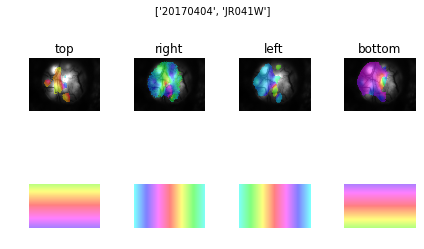

In [15]:
# -----------------------------------------------------------------------
# PLOT each selected condition:
# ----------------------------------------------------------------------   
nconds = len(mapinfo.keys())

threshold = 0.01

plt.figure()
for cidx,condkey in enumerate(mapinfo.keys()):
    mapinfo[condkey]['threshold'] = threshold
    mapinfo[condkey]['alpha'] = alpha_val
    #tmaps[condkey] = copy.copy(maps[condkey])
    #tmaps[condkey][np.where(ratios[condkey] < threshold)] = np.nan
    mapinfo[condkey]['thrphase'] = get_thresholded_maps(mapinfo[condkey]['phase'], mapinfo[condkey]['ratio'], threshold)

    # add run source info to dict:
    mapinfo[condkey]['averaging'] = CONDS[condkey]['averaging']
    mapinfo[condkey]['runs'] = CONDS[condkey]['runs_to_use']
    mapinfo[condkey]['condition'] = CONDS[condkey]['condition']

    plt.subplot(2,nconds,cidx+1)
    plt.title(condkey)
    plt.imshow(surface, cmap='gray')
    plt.imshow(mapinfo[condkey]['thrphase'], cmap=colormap, alpha=alpha_val)
    plt.axis('off')
    plt.subplot(2,nconds, cidx+nconds+1)
    plt.imshow(mapinfo[condkey]['legend'], cmap=colormap, alpha=alpha_val)
    plt.axis('off')

plt.tight_layout()
plt.suptitle([date, subject])

imname = 'thresholded_maps_thresh%0.4f_%s' % (threshold, colormap)
imname = imname.replace('.', 'x')

impath = os.path.join(fig_dir, imname+'.png')
plt.savefig(impath, bbox_inches='tight', pad_inches = 0)

#plt.show()

print impath


In [16]:
# -------------------------------------------------------
# Get phase maps of SINGLE runs, then, COMBINE runs (psuedo-average).
# -------------------------------------------------------
vmin_val = -1*math.pi # 0
vmax_val = math.pi


if get_combo:
    combomaps = dict()
    combomaps['comboAZ'] = dict()
    combomaps['comboEL'] = dict()

    left_phase = mapinfo['left']['phase']    
    if mapinfo['right']['averaging']:
        conj_right_phase = np.angle(D[mapinfo['right']['condition']][mapinfo['right']['runs'][0]]['ft'].conjugate())
    else:
        conj_right_phase = np.angle(D[mapinfo['right']['condition']][mapinfo['right']['runs']]['ft'].conjugate())

    tmp_az_combined = np.dstack((left_phase, conj_right_phase))
    tmp_az_cos = np.sum(np.cos(tmp_az_combined), 2)
    tmp_az_sin = np.sum(np.sin(tmp_az_combined), 2)
    combomaps['comboAZ']['phase'] = np.arctan2(tmp_az_sin, tmp_az_cos)

    top_phase = mapinfo['top']['phase']
    if mapinfo['bottom']['averaging']:
        conj_bottom_phase = np.angle(D[mapinfo['bottom']['condition']][mapinfo['bottom']['runs'][0]]['ft'].conjugate())
    else:
        conj_bottom_phase = np.angle(D[mapinfo['bottom']['condition']][mapinfo['bottom']['runs']]['ft'].conjugate())

    tmp_el_combined = np.dstack((top_phase, conj_bottom_phase))
    tmp_el_x = np.sum(np.cos(tmp_el_combined), 2)
    tmp_el_y = np.sum(np.sin(tmp_el_combined), 2)
    combomaps['comboEL']['phase'] = np.arctan2(tmp_el_y, tmp_el_x)

    combomaps['comboAZ']['ratio'] = (mapinfo['left']['ratio'] + mapinfo['right']['ratio'])/2.
    combomaps['comboAZ']['thrphase'] = get_thresholded_maps(combomaps['comboAZ']['phase'], combomaps['comboAZ']['ratio'], threshold)
    combomaps['comboAZ']['legend'] = V_left_legend

    combomaps['comboEL']['ratio'] = (mapinfo['top']['ratio'] + mapinfo['bottom']['ratio']) / 2.
    combomaps['comboEL']['thrphase'] = get_thresholded_maps(combomaps['comboEL']['phase'], combomaps['comboEL']['ratio'], threshold)
    combomaps['comboEL']['legend'] = H_top_legend


    if show_combo is True:
        plt.subplot(2,2,1)
        plt.imshow(surface, cmap='gray')
        plt.imshow(combomaps['comboAZ']['phase'], cmap=colormap, vmin=vmin_val, vmax=vmax_val, alpha=alpha_val)
        plt.axis('off')
        plt.subplot(2,2,3)
        plt.imshow(combomaps['comboAZ']['legend'], cmap=colormap, vmin=vmin_val, vmax=vmax_val, alpha=alpha_val)
        plt.axis('off')

        plt.subplot(2,2,2)
        plt.imshow(surface, cmap='gray')
        plt.imshow(combomaps['comboEL']['phase'], cmap=colormap, vmin=vmin_val, vmax=vmax_val, alpha=alpha_val)
        plt.axis('off')
        plt.subplot(2,2,4)
        plt.imshow(combomaps['comboEL']['legend'], cmap=colormap, vmin=vmin_val, vmax=vmax_val, alpha=alpha_val)
        plt.axis('off')

        plt.tight_layout()

        combo_figname = 'combined, thr: %0.4f' % threshold
        plt.suptitle([combo_figname, date, subject])

        imname = 'combophases_%s' % colormap

        impath = os.path.join(fig_dir, imname+'.png')
        plt.savefig(impath, bbox_inches='tight', pad_inches = 0)

        plt.show()



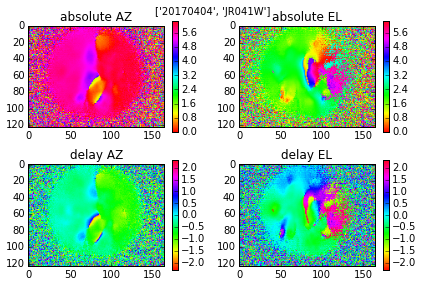

In [17]:
# --------------------------------------------------------------------------------------
# Get absolute maps:
# --------------------------------------------------------------------------------------
#AZphases = np.dstack((mapinfo['left']['phase'], mapinfo['right']['phase']))

def get_absolute_map(map1, map2):
    allphases = np.dstack((map1,map2))
    halfphase = np.true_divide(allphases[:,:,0], 2)
    halfphase2 = np.true_divide(allphases[:,:,1], 2)

    # Initial absolute phase map:
    abs_phase_map = halfphase - halfphase2

    # correct values where numerical problems are expected to arise(?):
    region2fix1 = np.logical_and(allphases[:,:,0] <= -np.true_divide(np.pi,2), allphases[:,:,1] <= -np.true_divide(np.pi,2))
    region2fix2 = np.logical_and(allphases[:,:,0] >= np.true_divide(np.pi,2), allphases[:,:,1]>=np.true_divide(np.pi,2))

    region2fix = np.logical_or(region2fix1, region2fix2)

    tmp_phase = np.copy(abs_phase_map)

    logical_idxs1 = np.logical_and(region2fix, abs_phase_map>0)
    tmp_phase[logical_idxs1] = abs_phase_map[logical_idxs1] - (np.pi)

    logical_idxs2 = np.logical_and(region2fix, abs_phase_map<0)
    tmp_phase[logical_idxs2] = abs_phase_map[logical_idxs2] + (np.pi)

    abs_phase_map = tmp_phase

    display_phase_map = np.copy(abs_phase_map)
    display_phase_map[abs_phase_map<0] = -abs_phase_map[abs_phase_map<0]
    display_phase_map[abs_phase_map>0] = (2*np.pi) - abs_phase_map[abs_phase_map>0]

    # Get delay map and correct:
    delay_map = halfphase + halfphase2
    delay_map[region2fix1] = np.pi + delay_map[region2fix1]
    delay_map[region2fix2] = delay_map[region2fix2] - np.pi
    
    return display_phase_map, delay_map


#plt.figure()


absmaps = dict()
absmaps['absoluteAZ'] = dict()
absmaps['absoluteEL'] = dict()

absmaps['absoluteAZ']['phase'], absmaps['absoluteAZ']['delay'] = get_absolute_map(mapinfo['left']['phase'], mapinfo['right']['phase'])
absmaps['absoluteEL']['phase'], absmaps['absoluteEL']['delay'] = get_absolute_map(mapinfo['top']['phase'], mapinfo['bottom']['phase'])

absmaps['absoluteAZ']['legend'], absmaps['absoluteAZ']['legendelay'] = get_absolute_map(mapinfo['left']['legend'], mapinfo['right']['legend'])
absmaps['absoluteEL']['legend'], absmaps['absoluteEL']['legendelay'] = get_absolute_map(mapinfo['top']['legend'], mapinfo['bottom']['legend'])

absmaps['absoluteAZ']['ratio'] = (mapinfo['left']['ratio'] + mapinfo['right']['ratio']) / 2.
absmaps['absoluteEL']['ratio'] = (mapinfo['top']['ratio'] + mapinfo['bottom']['ratio']) / 2.

plt.subplot(2,2,1)
plt.imshow(absmaps['absoluteAZ']['phase'], cmap=colormap)
plt.title('absolute AZ')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(absmaps['absoluteAZ']['delay'], cmap=colormap)
plt.title('delay AZ')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(absmaps['absoluteEL']['phase'], cmap=colormap)
plt.title('absolute EL')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(absmaps['absoluteEL']['delay'], cmap=colormap)
plt.title('delay EL')
plt.colorbar()

plt.tight_layout()

plt.suptitle([date, subject])

imname = 'absdelay_%s' % colormap
impath = os.path.join(fig_dir, imname+'.png')
plt.savefig(impath, bbox_inches='tight', pad_inches = 0)

plt.show()

In [26]:
delay_mask = False
delay_thr = 1.5
threshold=0.005

validAZ = np.copy(absmaps['absoluteAZ']['phase'])
validEL = np.copy(absmaps['absoluteEL']['phase'])

idxsAZ = np.logical_and(absmaps['absoluteAZ']['delay']<=delay_thr, absmaps['absoluteAZ']['delay']>=-delay_thr)
idxsEL = np.logical_and(absmaps['absoluteEL']['delay']<=delay_thr, absmaps['absoluteEL']['delay']>=-delay_thr)

validAZ[idxsAZ==False] = np.nan
validEL[idxsEL==False] = np.nan

absmaps['absoluteAZ']['valid'] = validAZ
absmaps['absoluteAZ']['delaythresh'] = delay_thr
absmaps['absoluteAZ']['delaymask'] = delay_mask

absmaps['absoluteEL']['valid'] = validEL
absmaps['absoluteEL']['delaythresh'] = delay_thr
absmaps['absoluteEL']['delaymask'] = delay_mask

if delay_mask:
    display_validAZ = np.copy(validAZ)
    display_validEL = np.copy(validEL)
else:
    display_validAZ = np.copy(absmaps['absoluteAZ']['phase'])   
    display_validEL = np.copy(absmaps['absoluteEL']['phase'])

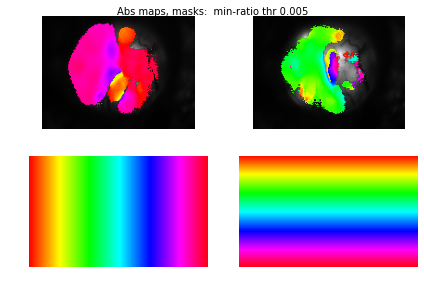

In [27]:


idxsAZmag = np.logical_and(mapinfo['left']['ratio']>threshold, mapinfo['right']['ratio']>threshold)
idxsELmag = np.logical_and(mapinfo['top']['ratio']>threshold, mapinfo['bottom']['ratio']>threshold)
display_validAZ[idxsAZmag==False] = np.nan
display_validEL[idxsELmag==False]= np.nan;

absmaps['absoluteAZ']['ratiothresh'] = threshold
absmaps['absoluteAZ']['displayAZ'] = display_validAZ
absmaps['absoluteEL']['ratiothresh'] = threshold
absmaps['absoluteEL']['displayEL'] = display_validEL


plt.subplot(2,2,1)
plt.imshow(surface, cmap='gray')
plt.imshow(display_validAZ, cmap='hsv')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(surface, cmap='gray')
plt.imshow(display_validEL, cmap='hsv')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(absmaps['absoluteAZ']['legend'], cmap=colormap)
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(absmaps['absoluteEL']['legend'], cmap=colormap)
plt.axis('off')

if delay_mask:
    abs_title_string = 'delay thr %0.3f,' % delay_thr
else:
    abs_title_string = ''
    
plt.suptitle('Abs maps, masks: %s min-ratio thr %0.3f' % (abs_title_string, threshold))

plt.tight_layout()

if delay_mask:
    delaystring = '_dthr%0.3f' % delay_thr
else:
    delaystring = '';

imname = '%s_%s_absMaps_c%s_thr%0.3f%s' % (date, subject, colormap, threshold, delaystring)

impath = os.path.join(fig_dir, imname+'.png')
plt.savefig(impath, bbox_inches='tight', pad_inches = 0)

plt.show()